# Imports

In [1]:
import os
import cv2
import time
import shutil
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# Hair Segmenter

In [2]:
def HairSegmenter(img, dilate):
    model_path = '/home/vuong.nguyen/vuong/augmentare/Bias Celeba/hair_segmenter.tflite'
    base_options = python.BaseOptions(model_asset_path=model_path)

    BaseOptions = mp.tasks.BaseOptions
    ImageSegmenter = mp.tasks.vision.ImageSegmenter
    ImageSegmenterOptions = mp.tasks.vision.ImageSegmenterOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    # Create a image segmenter instance with the image mode:
    options = ImageSegmenterOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE,
        output_category_mask=True)

    BG_COLOR = (0, 0, 0) # gray
    MASK_COLOR = (255, 255, 255) # white

    with ImageSegmenter.create_from_options(options) as segmenter:
        # Perform image segmentation on the provided single image.
        # The image segmenter must be created with the image mode.
        segmented_masks = segmenter.segment(img)
        category_mask = segmented_masks.category_mask

        # Generate solid color images for showing the output segmentation mask.
        image_data = img.numpy_view()
        fg_image = np.zeros(image_data.shape, dtype=np.uint8)
        fg_image[:] = MASK_COLOR
        bg_image = np.zeros(image_data.shape, dtype=np.uint8)
        bg_image[:] = BG_COLOR

        condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) > 0.2
        output_image = np.where(condition, fg_image, bg_image)
        mask = cv2.inRange(output_image, MASK_COLOR, MASK_COLOR)
        mask = np.clip(mask, 0, 1)

        kernel = np.ones((dilate, dilate), np.uint8)
        dilated_mask = cv2.dilate(mask, kernel)
    return mask, dilated_mask

In [3]:
# Load the input image from an image file.
align_path = '/home/vuong.nguyen/vuong/augmentare/Bias Celeba/dataset/img_align_celeba/000001.jpg'
img = cv2.imread(align_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
image = mp.Image.create_from_file(align_path)
mask, dilated_mask = HairSegmenter(image, 5)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


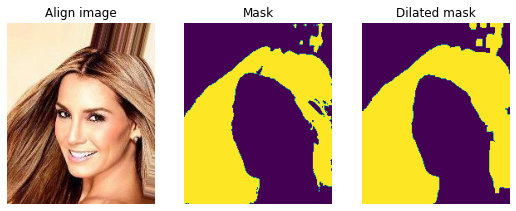

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,15))
ax[0].axis('off')
ax[0].imshow(img)
ax[0].set_title("Align image")
ax[1].axis('off')
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[2].axis('off')
ax[2].imshow(dilated_mask)
ax[2].set_title("Dilated mask")
plt.show()

# Get Mask and Create dataset

In [9]:
def get_mask(path_source, path_target, dilate, mode):
    files_list = sorted(os.listdir(path_source))
    for curr_file in files_list:
        shutil.copy(os.path.join(path_source, curr_file), os.path.join(f"{path_target}/imgs", curr_file))
        file_path = os.path.join(path_source, curr_file)

        img = mp.Image.create_from_file(file_path)

        _, dilated_mask = HairSegmenter(img, dilate)

        cv2.imwrite(f"{path_target}/mask/{curr_file}", dilated_mask)

    with open(f"{path_target}/paths.txt", "a+") as f:
        for curr_file in files_list:
            f.write(str(f"{mode}/imgs/{curr_file}") + ' ' + str(f"{mode}/mask/{curr_file}") + '\n')
    f.close()
    print("Doneeeee!")

In [10]:
path_source = "/home/vuong.nguyen/vuong/augmentare/joliGEN/dataset/male_gray_2_female_gray/trainA"
path_target = "/home/vuong.nguyen/vuong/augmentare/joliGEN/dataset/diffusion_hair_color_male/trainA"
dilate = 5
mode = "trainA"

In [11]:
get_mask(path_source, path_target, dilate, mode)

Doneeeee!
